In [1]:
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from typing import List

def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    return frames, alignments

def load_video(path:str) -> List[float]: 
    print(path)
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

In [2]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [3]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bbaf3s.mpg'))

data\s1\bbaf3s.mpg


In [4]:
### Compile the model
model.load_weights('models_1_e/checkpoint')
yhat = model.predict(tf.expand_dims(sample[0], axis=0))
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
e1 = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded][0].numpy().decode('utf-8')

1/1 [==============================] - 3s 3s/step


In [5]:
model.reset_states()

In [6]:
### Compile the model
model.load_weights('models_10_e/checkpoint')
yhat = model.predict(tf.expand_dims(sample[0], axis=0))
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
e10 = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded][0].numpy().decode('utf-8')

1/1 [==============================] - 1s 1s/step


In [7]:
model.reset_states()

In [8]:
### Compile the model
model.load_weights('models_15_e/checkpoint')
yhat = model.predict(tf.expand_dims(sample[0], axis=0))
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
e15 = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded][0].numpy().decode('utf-8')

1/1 [==============================] - 1s 978ms/step


In [9]:
model.reset_states()

In [10]:
### Compile the model
model.load_weights('models_25_e/checkpoint')
yhat = model.predict(tf.expand_dims(sample[0], axis=0))
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
e25 = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded][0].numpy().decode('utf-8')

1/1 [==============================] - 1s 949ms/step


In [11]:
model.reset_states()

In [12]:
### Compile the model
model.load_weights('models_50_e/checkpoint')
yhat = model.predict(tf.expand_dims(sample[0], axis=0))
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
e50 = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded][0].numpy().decode('utf-8')

1/1 [==============================] - 1s 944ms/step


In [13]:
model.reset_states()

In [14]:
### Compile the model
model.load_weights('models_100_e/checkpoint')
yhat = model.predict(tf.expand_dims(sample[0], axis=0))
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
e100 = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded][0].numpy().decode('utf-8')

1/1 [==============================] - 1s 934ms/step


In [18]:
real_text = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]][0].numpy().decode('utf-8')
print("Real Text : ",real_text)
print("Epoch 1 : ", e1) 
print("Epoch 10 : ", e10)
print("Epoch 15 : ", e15)
print("Epoch 25 : ", e25)
print("Epoch 50 : ", e50)
print("Epoch 100 : ", e100)

Real Text :  bin blue at f three soon
Epoch 1 :  le 
Epoch 10 :  lea re e oo
Epoch 15 :  plac re it ie a
Epoch 25 :  bin blue at ire on
Epoch 50 :  bin blue at three soon
Epoch 100 :  bin blue at j three soon


# Graph Plotting

In [21]:
import matplotlib.pyplot as plt
graph_x = [1,10,15,25,50,100]

## 1. Word Error Rate

In [27]:
def wer(reference, hypothesis):
    reference_words = reference.split()
    hypothesis_words = hypothesis.split()
    
    dp = [[0] * (len(hypothesis_words) + 1) for _ in range(len(reference_words) + 1)]
    
    for i in range(len(reference_words) + 1):
        dp[i][0] = i
        
    for j in range(len(hypothesis_words) + 1):
        dp[0][j] = j
    
    for i in range(1, len(reference_words) + 1):
        for j in range(1, len(hypothesis_words) + 1):
            if reference_words[i - 1] == hypothesis_words[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = min(dp[i - 1][j - 1], dp[i - 1][j], dp[i][j - 1]) + 1
                
    wer = dp[len(reference_words)][len(hypothesis_words)] / len(reference_words)
    return wer
# print("Word Error Rate : ",wer(real_text, predicted_text))

[1.0, 1.0, 1.0, 0.5, 0.16666666666666666, 0.16666666666666666]
[1, 10, 15, 25, 50, 100]


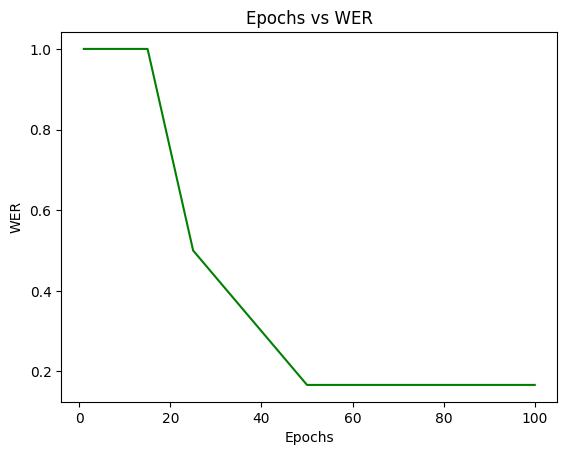

In [28]:
graph_wer_y = []
for i in [e1,e10,e15,e25,e50,e100]: 
    graph_wer_y.append(wer(real_text, i))
print(graph_wer_y)
print(graph_x)
plt.plot(graph_x, graph_wer_y,color = 'g') 
plt.xlabel("Epochs")
plt.ylabel("WER")
plt.title("Epochs vs WER")
# plt.xticks(graph_x) 
plt.show() 

## 2. Character Error Rate

In [29]:
def cer(reference, hypothesis):
    reference_chars = list(reference)
    hypothesis_chars = list(hypothesis)
    
    dp = [[0] * (len(hypothesis_chars) + 1) for _ in range(len(reference_chars) + 1)]
    
    for i in range(len(reference_chars) + 1):
        dp[i][0] = i
        
    for j in range(len(hypothesis_chars) + 1):
        dp[0][j] = j
    
    for i in range(1, len(reference_chars) + 1):
        for j in range(1, len(hypothesis_chars) + 1):
            if reference_chars[i - 1] == hypothesis_chars[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = min(dp[i - 1][j - 1], dp[i - 1][j], dp[i][j - 1]) + 1
                
    cer = dp[len(reference_chars)][len(hypothesis_chars)] / len(reference_chars)
    return cer
# print("Character Error Rate : ",cer(real_text, predicted_text))

[0.875, 0.625, 0.75, 0.2916666666666667, 0.08333333333333333, 0.041666666666666664]
[1, 10, 15, 25, 50, 100]


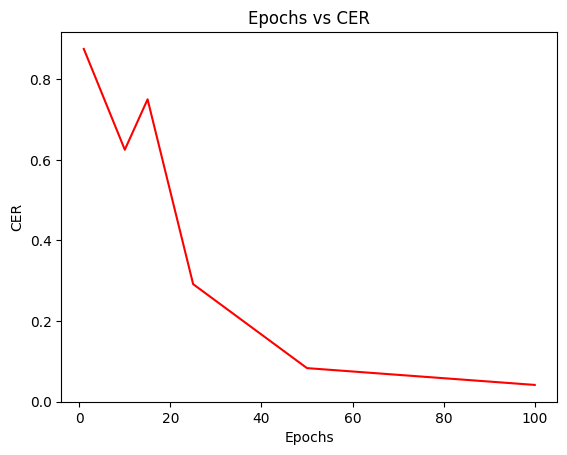

In [31]:
graph_cer_y = []
for i in [e1,e10,e15,e25,e50,e100]: 
    graph_cer_y.append(cer(real_text, i))
print(graph_cer_y)
print(graph_x)
plt.plot(graph_x, graph_cer_y,color = 'r') 
plt.xlabel("Epochs")
plt.ylabel("CER")
plt.title("Epochs vs CER")
# plt.xticks(graph_x) 
plt.show() 

## 3. Word Accuracy

In [35]:
def word_accuracy_percentage(reference, hypothesis):
    reference_words = reference.split()
    hypothesis_words = hypothesis.split()
    correct_words = sum(1 for ref, hyp in zip(reference_words, hypothesis_words) if ref == hyp)
    total_words = len(reference_words)
    accuracy = (correct_words / total_words) * 100
    return accuracy
# print(word_accuracy_percentage(real_text, predicted_text))

[0.0, 0.0, 0.0, 50.0, 50.0, 83.33333333333334]
[1, 10, 15, 25, 50, 100]


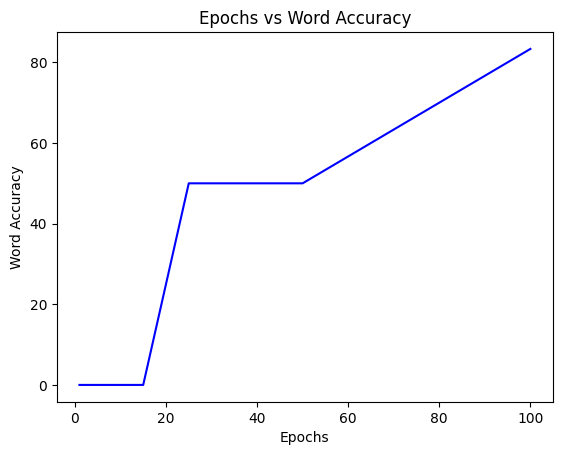

In [36]:
graph_wa_y = []
for i in [e1,e10,e15,e25,e50,e100]: 
    graph_wa_y.append(word_accuracy_percentage(real_text, i))
print(graph_wa_y)
print(graph_x)
plt.plot(graph_x, graph_wa_y,color = 'b') 
plt.xlabel("Epochs")
plt.ylabel("Word Accuracy")
plt.title("Epochs vs Word Accuracy")
# plt.xticks(graph_x) 
plt.show() 

## 4.F1 Score

In [37]:
def precision(reference, hypothesis):
    reference_words = set(reference.split())
    hypothesis_words = set(hypothesis.split())
    true_positives = len(reference_words.intersection(hypothesis_words))
    predicted_positives = len(hypothesis_words)
    precision = true_positives / predicted_positives if predicted_positives > 0 else 0
    return precision

def recall(reference, hypothesis):
    reference_words = set(reference.split())
    hypothesis_words = set(hypothesis.split())
    true_positives = len(reference_words.intersection(hypothesis_words))
    actual_positives = len(reference_words)
    recall = true_positives / actual_positives if actual_positives > 0 else 0
    return recall

def f1_score(reference, hypothesis):
    prec = precision(reference, hypothesis)
    rec = recall(reference, hypothesis)
    f1 = (2 * prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
    return f1
# print(precision(real_text, predicted_text))

[0, 0, 0, 0.5454545454545454, 0.9090909090909091, 0.8333333333333334]
[1, 10, 15, 25, 50, 100]


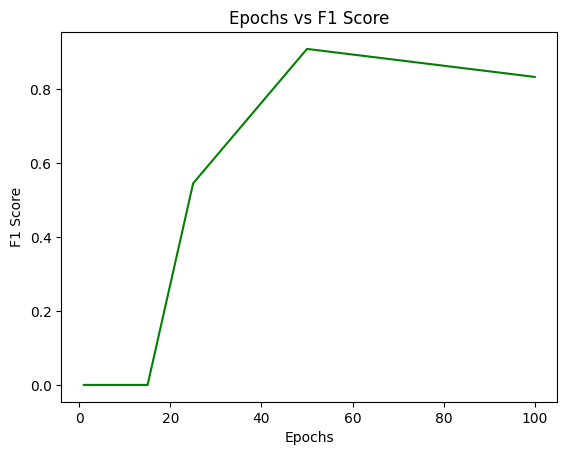

In [39]:
graph_f1_y = []
for i in [e1,e10,e15,e25,e50,e100]: 
    graph_f1_y.append(f1_score(real_text, i))
print(graph_f1_y)
print(graph_x)
plt.plot(graph_x, graph_f1_y,color = 'g') 
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Epochs vs F1 Score")
# plt.xticks(graph_x) 
plt.show() 

## 5. Bleu Score 

In [41]:
from nltk.translate.bleu_score import sentence_bleu

def bleu_score(reference, hypothesis):
    reference_tokens = [reference.split()]
    hypothesis_tokens = hypothesis.split()
    bleu = sentence_bleu(reference_tokens, hypothesis_tokens)
    bleu_score_decimal = "{:.3f}".format(bleu)
    return bleu,bleu_score_decimal
# print(bleu_score(real_text, predicted_text))

[0, 0, 0, 5.623118184955381e-78, 7.070696784820904e-78, 7.262123179505913e-78]
[1, 10, 15, 25, 50, 100]


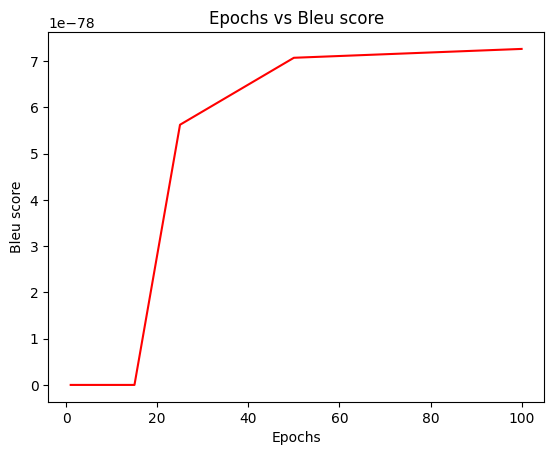

In [47]:
graph_bs_y = []
for i in [e1,e10,e15,e25,e50,e100]: 
    graph_bs_y.append(bleu_score(real_text, i)[0])
print(graph_bs_y)
print(graph_x)
plt.plot(graph_x, graph_bs_y,color = 'r') 
plt.xlabel("Epochs")
plt.ylabel("Bleu score")
plt.title("Epochs vs Bleu score")
# plt.xticks(graph_x) 
plt.show() 